Это моделька чтобы разобратся как это все работает некая изначальная моделька от которрой я буду отталкиватся


CUDA доступен: True
Количество GPU: 1
Название GPU: NVIDIA GeForce RTX 4070


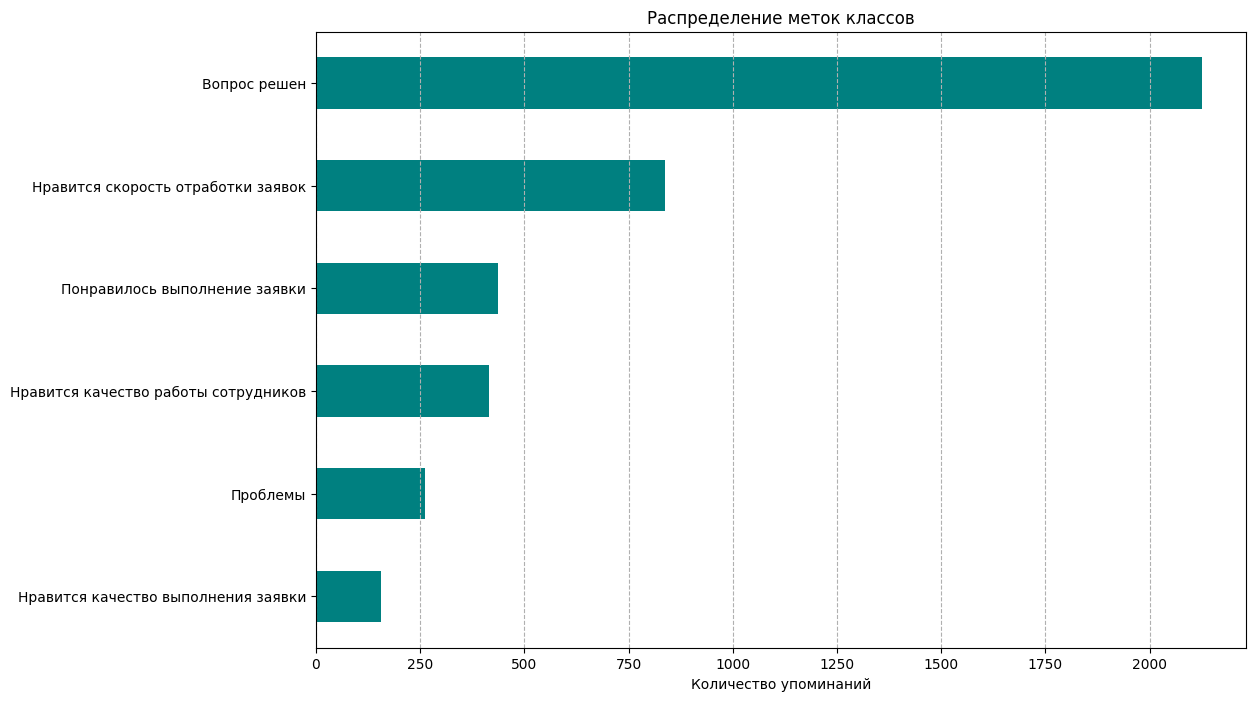

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Micro F1,Macro F1,Accuracy
1,0.499000,0.312994,0.777413,0.310147,0.540084
2,0.282600,0.207522,0.866708,0.674158,0.691983
3,0.192300,0.183494,0.877672,0.696236,0.681435
4,0.123700,0.159886,0.909513,0.852539,0.751055


                                      precision    recall  f1-score   support

                        Вопрос решен       0.96      0.97      0.97       422
 Нравится качество выполнения заявки       0.88      0.80      0.84        35
Нравится качество работы сотрудников       0.86      0.80      0.83        88
  Нравится скорость отработки заявок       0.94      0.95      0.95       182
       Понравилось выполнение заявки       0.68      0.75      0.71        80
                            Проблемы       0.82      0.83      0.83        54

                           micro avg       0.91      0.91      0.91       861
                           macro avg       0.86      0.85      0.85       861
                        weighted avg       0.91      0.91      0.91       861
                         samples avg       0.91      0.92      0.91       861



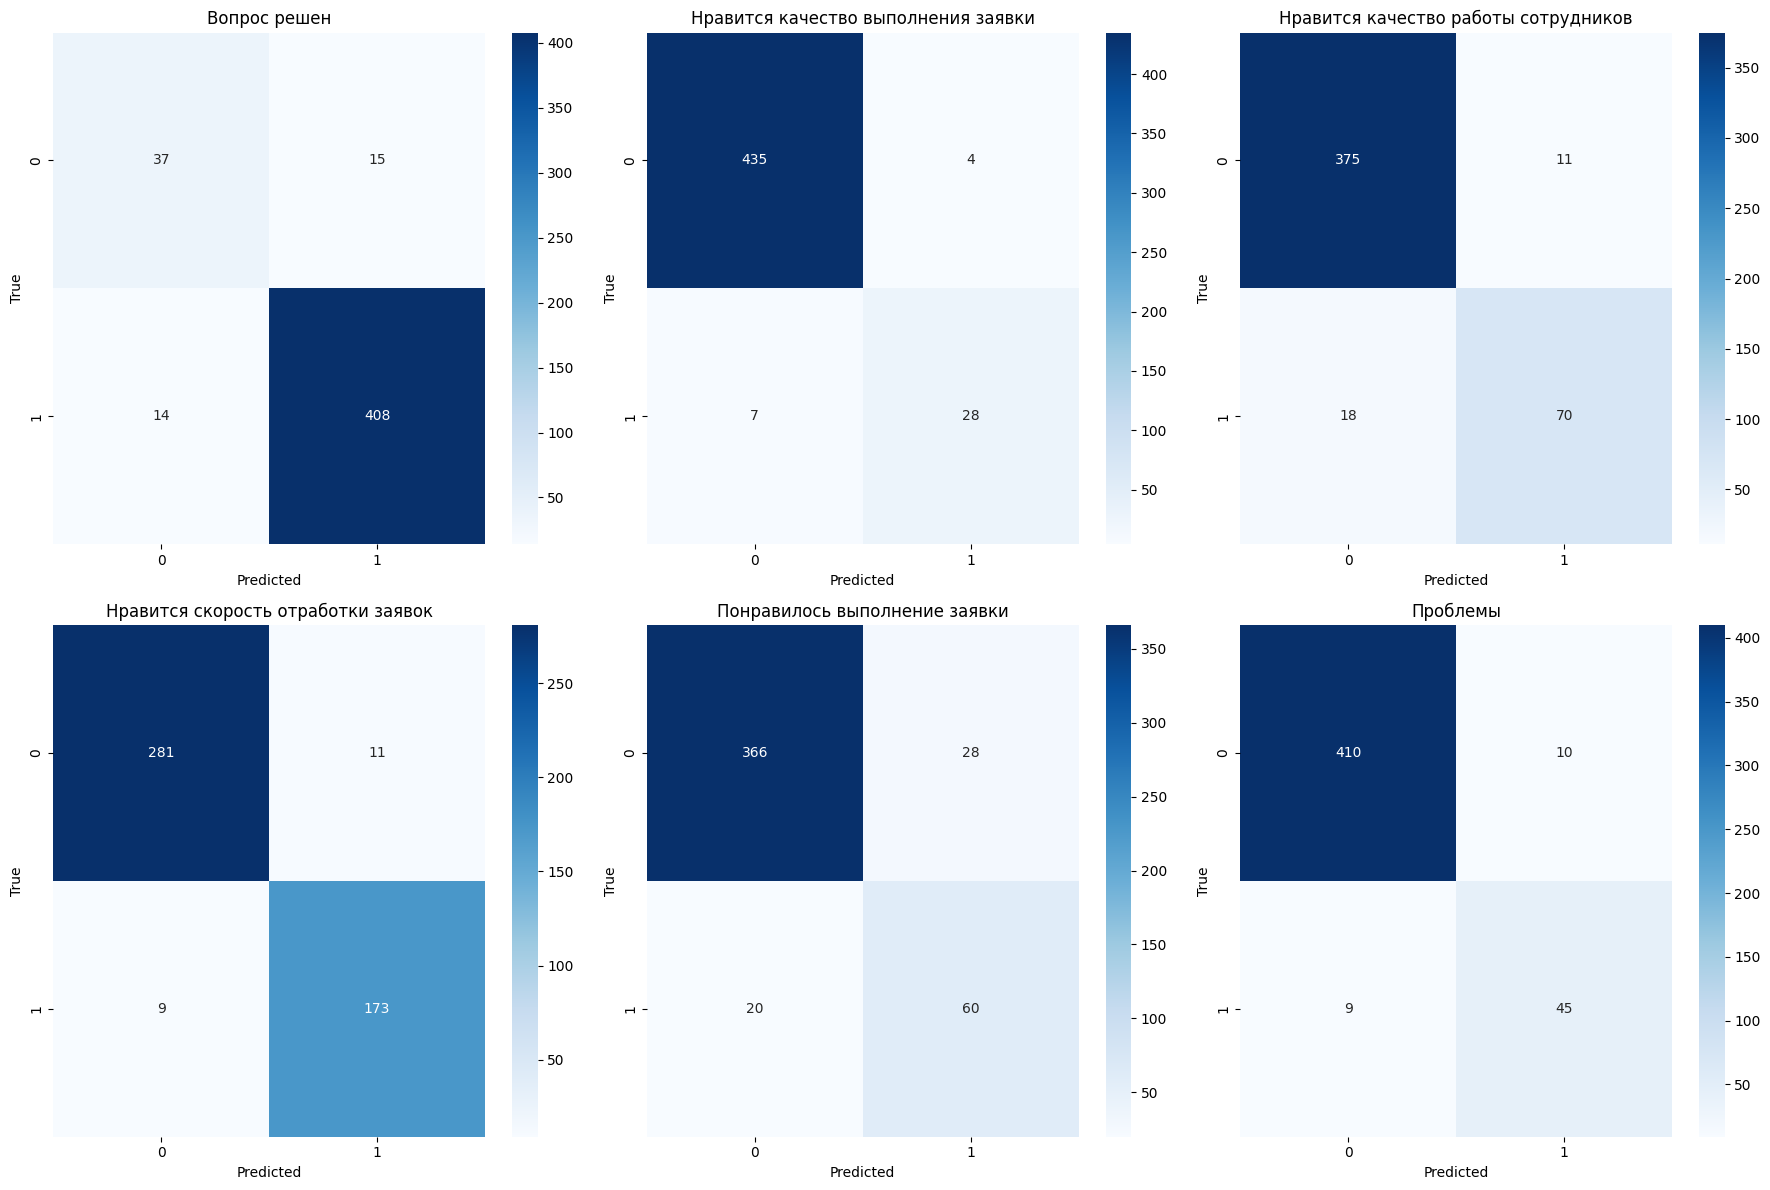


Micro-average ROC AUC: 0.9796
Macro-average ROC AUC: 0.9579

ROC AUC по классам:
Вопрос решен: 0.9581
Нравится качество выполнения заявки: 0.9673
Нравится качество работы сотрудников: 0.9715
Нравится скорость отработки заявок: 0.9795
Понравилось выполнение заявки: 0.9195
Проблемы: 0.9516


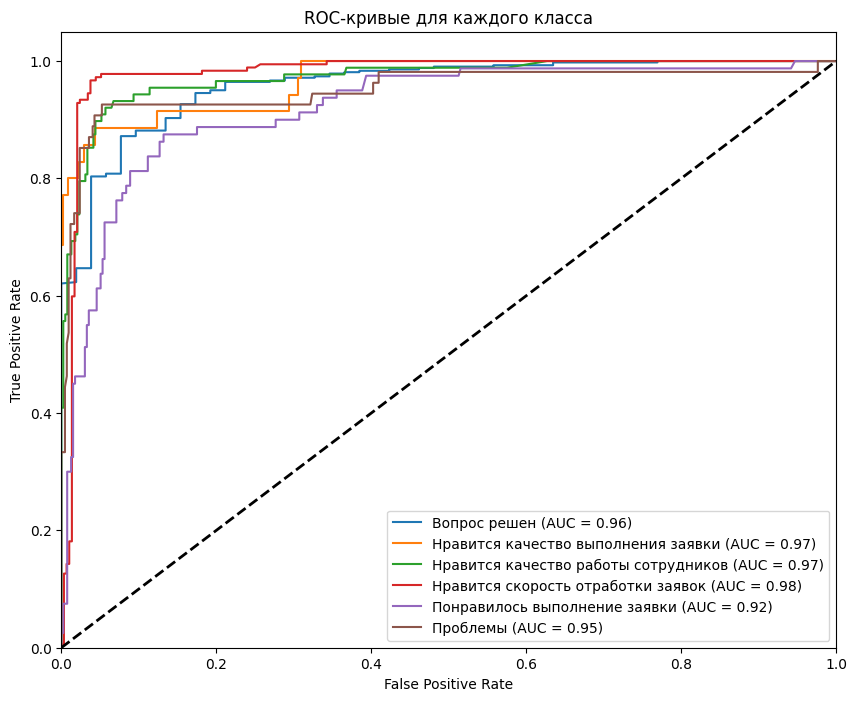

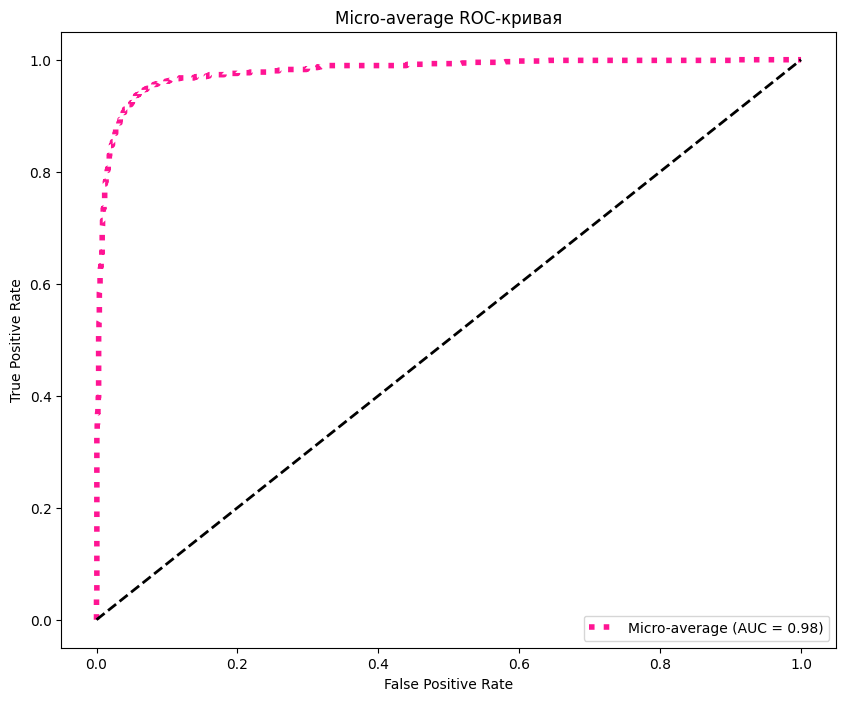

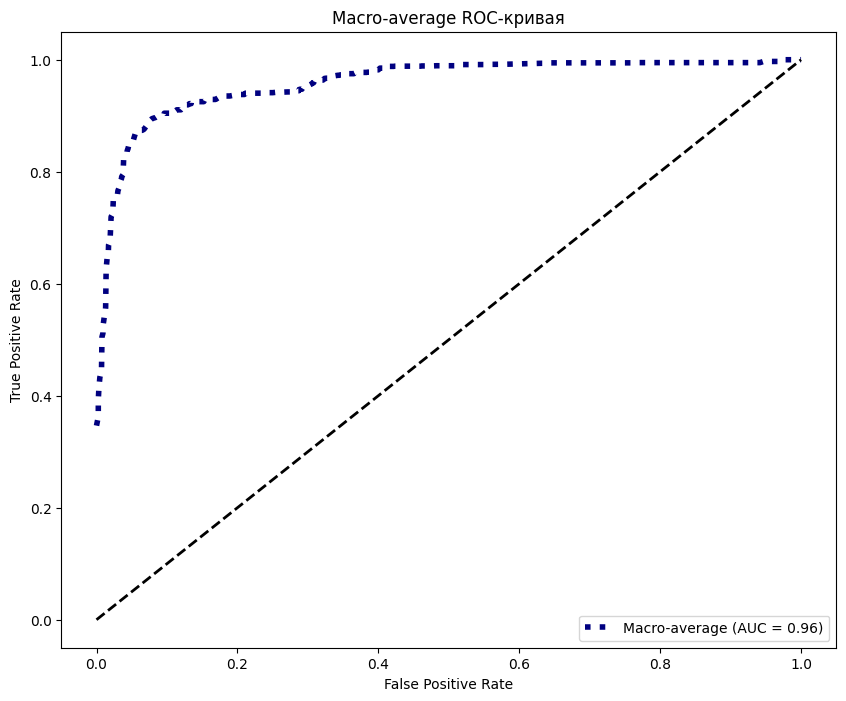

In [18]:
import pandas as pd
import numpy as np
import torch
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (
    f1_score, 
    accuracy_score, 
    confusion_matrix, 
    classification_report,
    roc_auc_score, 
    roc_curve, 
    auc
)
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments

# --- Проверка GPU ---
print(f"CUDA доступен: {torch.cuda.is_available()}")
print(f"Количество GPU: {torch.cuda.device_count()}")
print(f"Название GPU: {torch.cuda.get_device_name(0)}")

# --- Загрузка данных ---
df = pd.read_csv("obr.csv")
classes = [
    'Вопрос решен',
    'Нравится качество выполнения заявки',
    'Нравится качество работы сотрудников', 
    'Нравится скорость отработки заявок',
    'Понравилось выполнение заявки',
    'Проблемы'
]

# --- Визуализация распределения классов ---
plt.figure(figsize=(12, 8))
df[classes].sum().sort_values().plot(kind='barh', color='teal')
plt.title('Распределение меток классов')
plt.xlabel('Количество упоминаний')
plt.grid(axis='x', linestyle='--')
plt.show()

# --- Датасет ---
class MultiLabelDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length=128):
        self.encodings = tokenizer(
            texts,
            truncation=True,
            padding='max_length',
            max_length=max_length,
            return_tensors='pt'
        )
        self.labels = torch.FloatTensor(labels)

    def __getitem__(self, idx):
        return {
            'input_ids': self.encodings['input_ids'][idx],
            'attention_mask': self.encodings['attention_mask'][idx],
            'labels': self.labels[idx]
        }

    def __len__(self):
        return len(self.labels)

# --- Разделение данных ---
tokenizer = BertTokenizer.from_pretrained('bert-base-multilingual-cased')
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)

train_dataset = MultiLabelDataset(
    train_df['comment'].tolist(),
    train_df[classes].values,
    tokenizer
)

test_dataset = MultiLabelDataset(
    test_df['comment'].tolist(),
    test_df[classes].values,
    tokenizer
)

# --- Модель ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = BertForSequenceClassification.from_pretrained(
    'bert-base-multilingual-cased',
    num_labels=len(classes),
    problem_type="multi_label_classification"
).to(device)

# --- Аргументы обучения ---
training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=16,
    gradient_accumulation_steps=2,
    fp16=True,
    save_strategy='epoch',
    eval_strategy='epoch',
    warmup_steps=300,
    weight_decay=0.01,
    logging_dir='./logs',
    load_best_model_at_end=True,
    metric_for_best_model='micro_f1',
    logging_steps=100,
    report_to='none',
    dataloader_pin_memory=True,
    no_cuda=False,
)

# --- Метрики ---
def compute_metrics(p):
    preds = torch.sigmoid(torch.tensor(p.predictions)) > 0.5
    return {
        'micro_f1': f1_score(p.label_ids, preds, average='micro'),
        'macro_f1': f1_score(p.label_ids, preds, average='macro'),
        'accuracy': accuracy_score(p.label_ids, preds)
    }

# --- Обучение ---
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    compute_metrics=compute_metrics
)

trainer.train()

# --- Предсказания ---
predictions = trainer.predict(test_dataset)

# --- Обработка предсказаний ---
logits = predictions.predictions  # Для версий transformers >= 4.0
probs = torch.sigmoid(torch.tensor(logits)).numpy()
y_true = test_df[classes].values

# --- Классификационный отчет ---
preds = (probs > 0.5).astype(int)
print(classification_report(
    y_true,
    preds,
    target_names=classes,
    zero_division=0
))

# --- Confusion Matrix ---
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
for i, (cls, ax) in enumerate(zip(classes, axes.flatten())):
    cm = confusion_matrix(y_true[:, i], preds[:, i])
    sns.heatmap(cm, annot=True, fmt='d', ax=ax, cmap='Blues')
    ax.set_title(cls)
    ax.set_xlabel('Predicted')
    ax.set_ylabel('True')
plt.tight_layout()
plt.show()

# --- ROC-анализ ---
# ROC AUC для каждого класса
roc_auc = {}
for i, cls in enumerate(classes):
    roc_auc[cls] = roc_auc_score(y_true[:, i], probs[:, i])

# Micro и Macro ROC AUC
micro_roc_auc = roc_auc_score(y_true.ravel(), probs.ravel())
macro_roc_auc = np.mean(list(roc_auc.values()))

print(f"\nMicro-average ROC AUC: {micro_roc_auc:.4f}")
print(f"Macro-average ROC AUC: {macro_roc_auc:.4f}\n")
print("ROC AUC по классам:")
for cls, score in roc_auc.items():
    print(f"{cls}: {score:.4f}")

# ROC-кривые для классов
plt.figure(figsize=(10, 8))
for i, cls in enumerate(classes):
    fpr, tpr, _ = roc_curve(y_true[:, i], probs[:, i])
    roc_auc_cls = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'{cls} (AUC = {roc_auc_cls:.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривые для каждого класса')
plt.legend(loc="lower right")
plt.show()

# Micro-average ROC
fpr_micro, tpr_micro, _ = roc_curve(y_true.ravel(), probs.ravel())
roc_auc_micro = auc(fpr_micro, tpr_micro)

plt.figure(figsize=(10, 8))
plt.plot(fpr_micro, tpr_micro, 
         label=f'Micro-average (AUC = {roc_auc_micro:.2f})',
         color='deeppink', linestyle=':', linewidth=4)
plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Micro-average ROC-кривая')
plt.legend(loc="lower right")
plt.show()

# Macro-average ROC
all_fpr = np.unique(np.concatenate(
    [roc_curve(y_true[:, i], probs[:, i])[0] for i in range(len(classes))]
))
mean_tpr = np.zeros_like(all_fpr)
for i in range(len(classes)):
    fpr, tpr, _ = roc_curve(y_true[:, i], probs[:, i])
    mean_tpr += np.interp(all_fpr, fpr, tpr)
mean_tpr /= len(classes)

roc_auc_macro = auc(all_fpr, mean_tpr)

plt.figure(figsize=(10, 8))
plt.plot(all_fpr, mean_tpr,
         label=f'Macro-average (AUC = {roc_auc_macro:.2f})',
         color='navy', linestyle=':', linewidth=4)
plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Macro-average ROC-кривая')
plt.legend(loc="lower right")
plt.show()